In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import datetime as Date
from crypto.libs.marketcap import MarketCap
from crypto.libs.price import Price
from crypto.libs.coins import Coins
from crypto.libs.scraping.refresh import run as MarketCapInit
from crypto.libs import dateutils
import pandas as pd
import datetime

In [2]:
import sklearn
from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

/Users/sanchez/Projects/py/Anaconda/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
price = Price()
coins = Coins()
marketcap = MarketCap()

In [4]:
period_increase = 7

In [5]:
last_available_date = pd.to_datetime(max(price.dataset["Date"].values)).date()
last_scraping_date = last_available_date + datetime.timedelta(days = -period_increase)
start_scraping_date = last_scraping_date + datetime.timedelta(weeks = -52)
last_available_date
last_scraping_date
start_scraping_date

datetime.date(2018, 1, 7)

datetime.date(2017, 12, 31)

datetime.date(2017, 1, 1)

In [6]:
exchanges = ["Poloniex", "Binance", "Bitstamp"]
universe = coins.exchanges(exchanges)
len(universe)

150

In [7]:
current_date = start_scraping_date
i = 0
one_year_in_seconds = 60*60*24*365
ml_data = []
ml_target = []
while current_date < last_scraping_date:
    print (current_date)
    current_date = current_date + datetime.timedelta(days=7)
    current_datetime = datetime.datetime(current_date.year, current_date.month, current_date.day)
    next_week_date = current_date + datetime.timedelta(days=7)
    next_week_datetime = datetime.datetime(next_week_date.year, next_week_date.month, next_week_date.day)
    coins_for_date = set(price.dataset[price.dataset["Date"] == current_date]["Symbol"].values)
    
    for coin in coins_for_date:
        # features 
        if coin == "BTC":
            continue
        try:
            coin_rank = marketcap.rank(coin, current_date)
            coin_age = round((current_date - coins.coin_data(coin, "ICO").date()).total_seconds() / one_year_in_seconds, 2)
            coin_price = price.historical(coin, "USD", current_datetime)
            coin_increase = price.historical(coin, "USD", next_week_datetime) / coin_price - 1 

            # target
            should_buy = coin_increase > 0.5
            
            ml_data.append({"Rank": coin_rank, 
                           "Age": coin_age,
                           "Price": coin_price})
            ml_target.append(should_buy)
        except:
            print ("Issue with {}".format(coin))

2017-01-01
Issue with OP
Issue with NODC
Issue with TALK
Issue with XID
Issue with SPEX
Issue with ION
Issue with BIOS
Issue with AMS
Issue with ZMC
Issue with THS
Issue with 888
Issue with GPU
Issue with GAIA
Issue with BIGUP
Issue with POKE
2017-01-08
Issue with FRC
Issue with TRICK
Issue with XAU
Issue with Q2C
Issue with WMC
Issue with MST
Issue with BTSR
Issue with JINN
Issue with OCOW
2017-01-15
Issue with BTCS
Issue with GOLF
Issue with BRIT
Issue with UBQ
Issue with THS
Issue with IMPS
2017-01-22
Issue with GRE
Issue with SKC
Issue with XQN
Issue with SOIL
Issue with SFE
Issue with HAL
Issue with MKR
Issue with UTC
2017-01-29
Issue with FRC
Issue with XAU
Issue with OMC
Issue with FLAX
Issue with AGLC
Issue with GOLF
Issue with XPY
Issue with FIRE
Issue with TCR
Issue with GML
Issue with RC
Issue with DRM
Issue with QBT
Issue with BUMBA
Issue with RED
Issue with JINN
Issue with XPD
Issue with DLISK
Issue with OCOW
2017-02-05
Issue with GRE
Issue with VTA
Issue with PHS
Issue wi

In [4]:
ml_features = ["Rank", "Age", "Price"]
#mlData = pd.DataFrame(ml_data, columns = ml_features)

In [24]:
#mlData.to_csv("mldata.csv")

In [25]:
#mlTarget = pd.DataFrame(ml_target)

In [26]:
#mlTarget.to_csv("mltarget.csv")

In [6]:
mlData = pd.DataFrame.from_csv("mldata.csv")
mlTarget = pd.DataFrame.from_csv("mltarget.csv")

In [8]:
mlData["Target"] = mlTarget

In [10]:
mlData = mlData.dropna()

In [17]:
mlData = mlData[["Rank", "Age", "Price"]]

In [15]:
ml_targ = list(mlData["Target"].values)

In [12]:
import numpy as np

In [18]:
mlData.head()

,Rank,Age,Price
0,175,2.92,0.000064
1,481,0.15,0.000091
2,31,2.39,0.136110
3,337,2.19,0.001820
4,32,0.33,0.132609


In [26]:
len(mlData)

44055

In [28]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
    mlData, ml_targ, test_size=0.5, random_state=42)

In [29]:
estimator = DecisionTreeClassifier(max_leaf_nodes=7, random_state=0)
estimator.fit(X_train, Y_train)

predictions = estimator.predict(X_test)
expected = Y_test

print (estimator.score(X_test, Y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

0.843517341565


In [30]:
from sklearn.tree import export_graphviz
import graphviz


In [31]:
sklearn.__version__

'0.19.1'

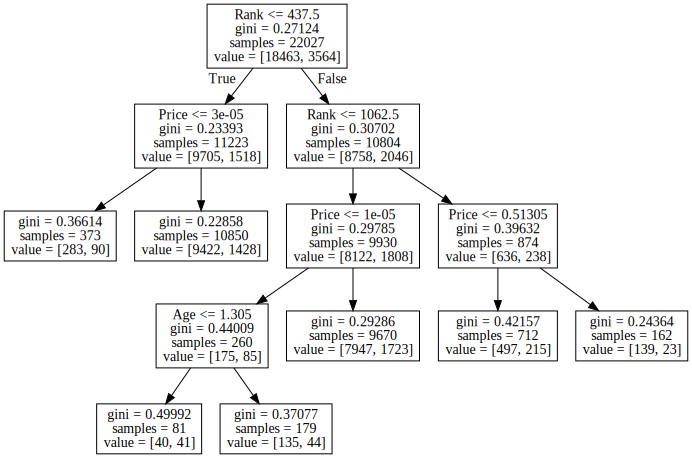

In [32]:
sklearn.tree.export_graphviz(estimator, 
                             out_file="mytree.dot", 
                             feature_names=ml_features, 
                             proportion=False, 
                             precision=5)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)